In [47]:
from pathlib import Path

import numpy as np
import pandas as pd 
from transformers import RobertaModel, RobertaTokenizer
from datasets import Dataset
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import torch 
from umap import UMAP

In [3]:
DATA_PATH = Path(r'../input/737-ata-4plus')
data_file = '2023-03-31_737_ata-master-list-4plus.csv'

col_text = 'Title'

df = pd.read_csv(DATA_PATH.joinpath(data_file))

In [4]:
data = Dataset.from_pandas(df)

In [14]:
model_ckpt = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_ckpt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def tokenize_batch(batch): 
    return tokenizer(batch[col_text], padding=True, truncation=True)

In [7]:
# Example with first two texts: 
tokenize_batch(data[:2])

{'input_ids': [[0, 7613, 8167, 45119, 230, 4546, 26896, 2, 1, 1, 1, 1, 1], [0, 7613, 8167, 45119, 230, 4546, 26896, 23464, 22980, 12435, 6324, 19569, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [8]:
# Encoding the full dataset
data_encoded = data.map(tokenize_batch, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
data_encoded

Dataset({
    features: ['ATA', 'Title', 'input_ids', 'attention_mask'],
    num_rows: 480
})

In [20]:
def extract_hidden_states(batch): 
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad(): 
        last_hidden_state = model(**inputs).last_hidden_state
    return {'cls_hidden_state': last_hidden_state[:, 0, :].cpu().numpy()}

In [18]:
data_encoded.set_format('torch', columns=['input_ids', 'attention_mask'])

In [21]:
data_hidden_state = data_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
data_hidden_state

Dataset({
    features: ['ATA', 'Title', 'input_ids', 'attention_mask', 'cls_hidden_state'],
    num_rows: 480
})

In [25]:
data_hidden_state['cls_hidden_state'].shape

torch.Size([480, 768])

In [31]:
X = np.array(data_hidden_state['cls_hidden_state'])
X.shape

(480, 768)

In [32]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.043337,0.072313,-0.020343,-0.102101,0.056351,-0.090035,-0.045033,-0.008111,0.056988,-0.060410,...,0.040397,0.000103,-0.034320,-0.083389,0.023965,0.128978,0.066766,-0.036580,-0.057320,-0.028288
1,-0.030184,0.065612,-0.022094,-0.103319,0.059147,-0.112213,-0.056607,-0.009831,0.052056,-0.056667,...,0.031662,-0.007099,-0.043329,-0.091752,0.013569,0.128143,0.061553,-0.050738,-0.048170,-0.010134
2,-0.037469,0.068109,-0.020356,-0.095122,0.057912,-0.081640,-0.047427,-0.011610,0.061793,-0.054412,...,0.040711,-0.012637,-0.031732,-0.078692,0.020380,0.127667,0.072776,-0.045248,-0.045891,-0.003501
3,-0.039911,0.063098,-0.031918,-0.088520,0.082917,-0.067343,-0.049897,-0.013888,0.050750,-0.062029,...,0.030143,-0.016558,-0.029927,-0.088950,0.029555,0.125436,0.069403,-0.043279,-0.054016,-0.010321
4,-0.051974,0.062987,-0.040034,-0.084519,0.058721,-0.111527,-0.048928,-0.036384,0.054467,-0.052409,...,0.031693,-0.009302,-0.036366,-0.089695,0.013896,0.123565,0.082726,-0.045615,-0.046736,-0.017238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-0.037788,0.077748,-0.016406,-0.106750,0.071234,-0.100881,-0.053556,0.003826,0.057548,-0.067342,...,0.018085,-0.001806,-0.053124,-0.089417,-0.005120,0.131739,0.083909,-0.063713,-0.066491,-0.013672
476,-0.035686,0.065790,-0.023826,-0.092666,0.068696,-0.100354,-0.062453,-0.000258,0.047921,-0.064668,...,0.011839,-0.006716,-0.047534,-0.105154,-0.013823,0.129572,0.085534,-0.065737,-0.067294,-0.013190
477,-0.031589,0.079478,-0.029845,-0.094104,0.066168,-0.103227,-0.042377,-0.001380,0.058231,-0.073537,...,0.034539,0.001434,-0.048477,-0.093479,-0.015042,0.123939,0.072668,-0.058130,-0.071653,-0.000699
478,-0.027790,0.081390,-0.027330,-0.107812,0.083266,-0.098255,-0.048943,-0.002449,0.054963,-0.068886,...,0.025699,0.000735,-0.049783,-0.096074,0.001775,0.121580,0.075951,-0.053483,-0.067647,-0.013358


In [54]:
y = np.array([ata[:2] for ata in data_hidden_state['ATA']])

## Visualization with UMAP

In [56]:
X_scaled = MinMaxScaler().fit_transform(X)

In [57]:
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

In [58]:
mapper

UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [59]:
df_umap_2d = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_umap_2d['label'] = y

In [60]:
df_umap_2d

,X,Y,label
0,4.898927,6.507364,27
1,11.198781,7.056646,27
2,4.744271,6.614544,27
3,5.152993,6.831776,27
4,4.799506,6.512117,27
...,...,...,...
475,5.328936,6.331081,52
476,5.378141,5.746300,52
477,5.109763,5.317360,52
478,5.090641,5.782128,52


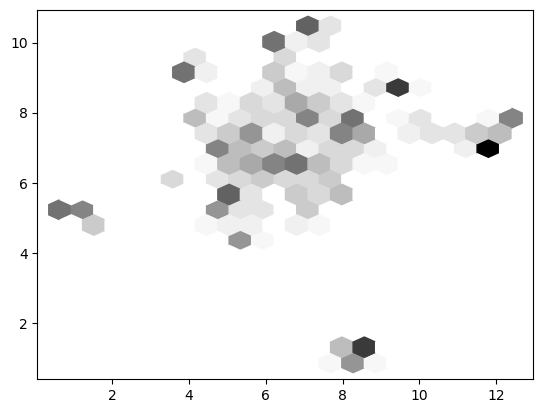

In [74]:
fig, ax = plt.subplots()
ax.hexbin(
    df_umap_2d['X'],
    df_umap_2d['Y'],
    cmap="Greys", 
    gridsize=20
)
fig.show()

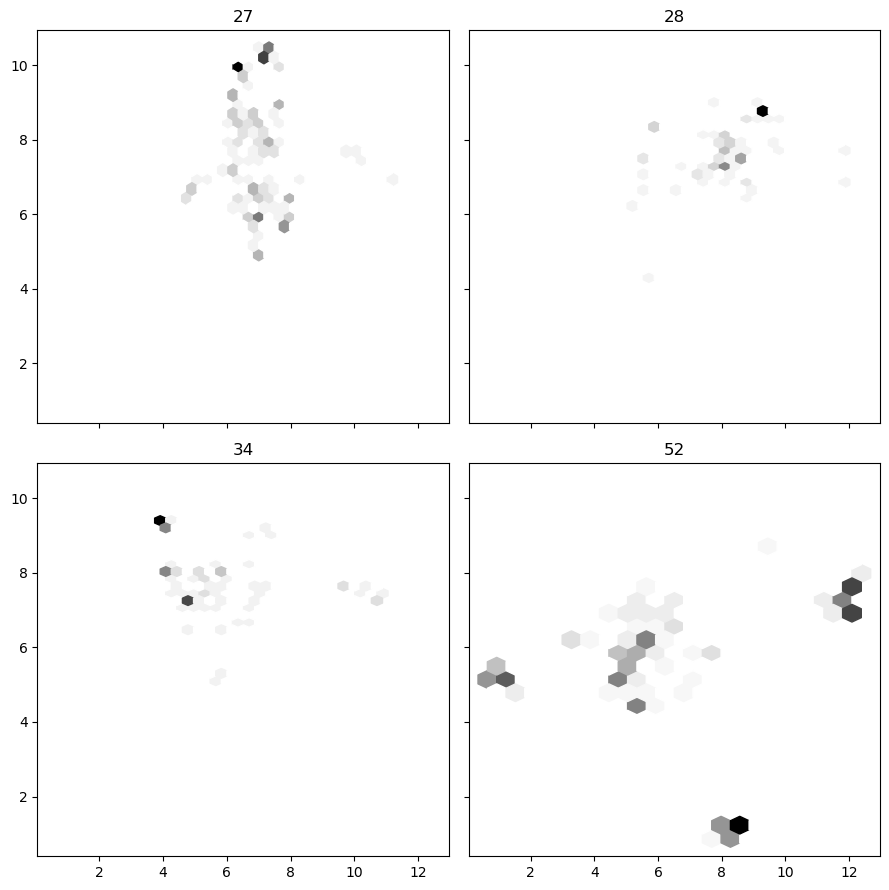

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(9,9), sharex=True, sharey=True)
axes = axes.flatten()
labels = df_umap_2d['label'].unique()
cmap = "Greys"

for i, label in enumerate(labels): 
    df_umap_sub = df_umap_2d.query('label==@label')
    axes[i].hexbin(
        df_umap_sub['X'], 
        df_umap_sub['Y'], 
        cmap=cmap, 
        gridsize=20
    )
    axes[i].set_title(label)
plt.tight_layout()
plt.show()
    